In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [12]:
h5 = '../cerberus/cerberus_annot.h5'
h5_trip = 'cerberus_annot_triplets.h5'
ab = '../talon/mouse_talon_abundance.tsv'
filt_ab = '../cerberus/cerberus_filtered_abundance.tsv'
obs_col = 'sample'
species='mouse'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
gene_subset = 'polya'

In [3]:
ca = cerberus.read(h5_trip)

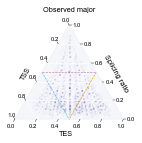

In [4]:
# Observed major isos
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'obs_major'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed major',
            size_scale=0.2,
            density_cbar=False,
            fname='figures/simplex_obs_major.pdf')

In [5]:
temp = assign_gisx_sector(temp)
beep = temp

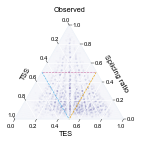

In [6]:
# Observed
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'obs_det'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed',
            size_scale=0.2,
            density_cbar=False,
            fname='figures/simplex_obs_det.pdf')

In [7]:
temp = assign_gisx_sector(temp)
beep = pd.concat([temp, beep])


Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1762: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1761: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 252602
# genes >= 1 tpm: 177043
Applying gene type and novelty subset
Number of genes reported: 27003


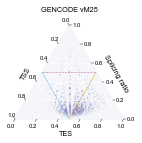

In [13]:
# gencode vM25 from detected polya genes only
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   gene_subset=gene_subset,
                   species=species,
                   min_tpm=min_tpm)

temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'vM25', 'gid': inds},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='GENCODE vM25',
            size_scale=0.2,
            density_cbar=False,
            fname='figures/simplex_vM25_det.pdf')

In [14]:
temp = assign_gisx_sector(temp)
beep = pd.concat([temp, beep])

In [15]:
beep[['source', 'gid']].groupby('source').count()

,gid
source,
obs_det,22429
obs_major,22429
vM25,27003


In [16]:
counts = beep
temp = pd.DataFrame()
for source in counts.source.unique():
    df = assign_gisx_sector(counts)
    df = df.loc[df.source == source]
    df = df[['gid', 'source', 'sector']].groupby(['source', 'sector']).count().reset_index()
    df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    df['total_genes'] = df.n_genes.sum()
    temp = pd.concat([temp, df])
temp['perc'] = (temp.n_genes/temp.total_genes)*100

In [17]:
temp.to_csv('genes_per_sector.tsv', sep='\t', index=False)

In [18]:
temp = pd.read_csv('genes_per_sector.tsv', sep='\t')

<Figure size 216x1440 with 0 Axes>

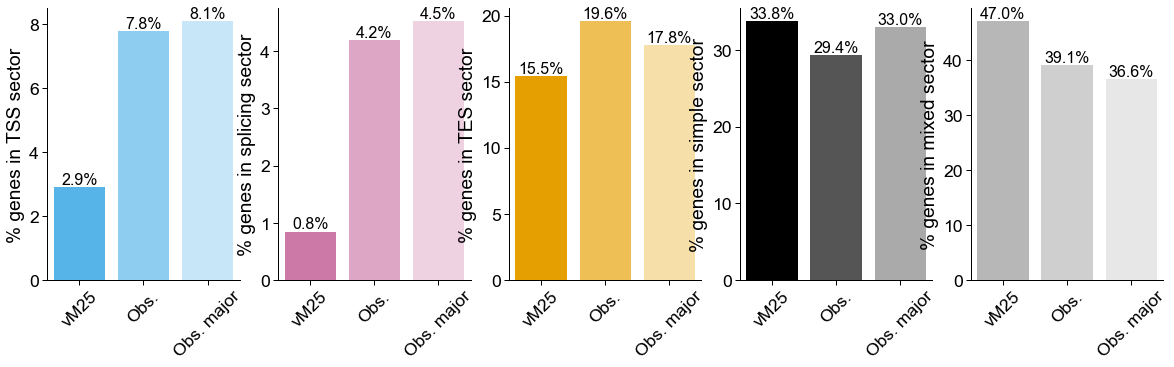

In [21]:
cat1 = 'sector'
cat2 = 'source'
cat2_order = ['vM25', 'obs_det', 'obs_major']
cat1_order = ['tss', 'splicing', 'tes', 'simple', 'mixed']
parent_c_dict, parent_order = get_sector_colors()

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,20))
fig, axes = plt.subplots(1, len(cat1_order), figsize=(20,5))


# #create chart in each subplot
# sns.boxplot(data=df, x='team', y='points', ax=axes[0,0])
# sns.boxplot(data=df, x='team', y='assists', ax=axes[0,1])

# loop through first category
for i, c1 in enumerate(cat1_order):
    beep = temp.loc[temp[cat1] == c1]
    
    c = parent_c_dict[c1]
    c_dict, order = get_shade_colors(c, cat2_order)
    
    # plotting
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    # plt.figure(figsize=(3,4))

    ax = sns.barplot(data=beep, y='perc', x=cat2,
                     palette=c_dict, order=order,
                     saturation=1, ax=axes[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    if c1 in ['tss', 'tes']:
        c1 = c1.upper()
    ylabel = '% genes in {} sector'.format(c1)

    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.tick_params(axis="x", rotation=45)    
    ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])
    fname = 'figures/genes_{}_by_sector.pdf'.format(c1)
    
    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            # x = p.get_x() + p.get_width() / 2 - 0.3
            # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')


    add_perc_2(ax)
fname = 'figures/genes_by_sector.pdf'
# plt.show()
# plt.subplots_adjust(wspace=0.35)
# plt.tight_layout()
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")
    